<a href="https://colab.research.google.com/github/SriCharan2705/HealthSync-AI/blob/main/HealthSync_AI_ModelComparasion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Random Forest vs Neural Networks

Step 1: Install Required Libraries

In [1]:
!pip install pandas numpy scikit-learn joblib imbalanced-learn xgboost tensorflow matplotlib seaborn


Step 2: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


Step 3: Load Dataset from Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')


file_path = "/content/drive/My Drive/HealthSyncAI/Synthetic_health_dataset.csv"
df = pd.read_csv(file_path)


df.head()


Mounted at /content/drive


,glucose,cholesterol,HbA1c,BMI,blood_pressure,sleep_hours,age,smoking_status,alcohol_intake,physical_activity,diet_habits,gender,medical_history,disease_status
0,109,202,6.7,31.8,143,8.2,51,Yes,No,Yes,Balanced,Male,NaN,Diabetes
1,97,198,4.5,24.5,118,7.4,24,No,Yes,Yes,Vegan,Male,Heart Disease,Heart Disease
2,112,228,6.3,19.6,100,8.7,56,No,No,No,High-Fat,Female,Heart Disease,Hypertension
3,130,245,5.1,32.0,99,6.4,26,No,Yes,No,High-Fat,Male,Diabetes,Hypertension
4,95,220,5.4,24.4,114,6.8,44,No,No,No,Low-Carb,Male,Heart Disease,Heart Disease


Step 4: Handle Missing Values & Outliers

Missing values per column:
 glucose                  0
cholesterol              0
HbA1c                    0
BMI                      0
blood_pressure           0
sleep_hours              0
age                      0
smoking_status           0
alcohol_intake           0
physical_activity        0
diet_habits              0
gender                   0
medical_history      12641
disease_status           0
dtype: int64


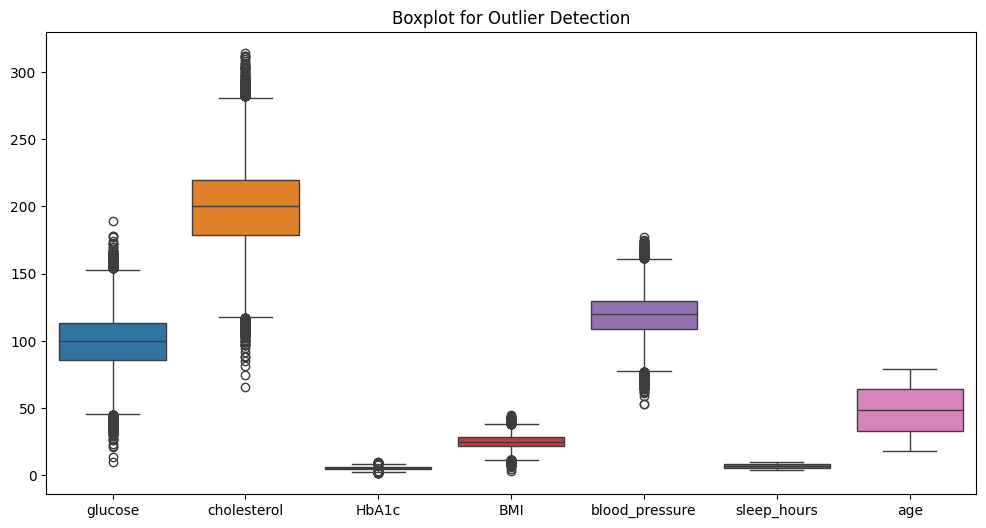

Outliers handled successfully!


In [4]:

print("Missing values per column:\n", df.isnull().sum())


df.fillna(df.median(numeric_only=True), inplace=True)


df.fillna(df.mode().iloc[0], inplace=True)


plt.figure(figsize=(12,6))
sns.boxplot(data=df[['glucose', 'cholesterol', 'HbA1c', 'BMI', 'blood_pressure', 'sleep_hours', 'age']])
plt.title("Boxplot for Outlier Detection")
plt.show()


for col in ['glucose', 'cholesterol', 'HbA1c', 'BMI', 'blood_pressure', 'sleep_hours', 'age']:
    lower_bound = df[col].quantile(0.05)
    upper_bound = df[col].quantile(0.95)
    df[col] = np.clip(df[col], lower_bound, upper_bound)

print("Outliers handled successfully!")


Step 5: Encode Labels

In [5]:

X = df.drop(columns=['disease_status'])
y = df['disease_status']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


joblib.dump(label_encoder, "label_encoder.pkl")

print("Target labels encoded successfully:", label_encoder.classes_)


Target labels encoded successfully: ['Diabetes' 'Healthy' 'Heart Disease' 'Hypertension']


Step 6: One-Hot Encode Categorical Features & Scale Numerical Features

In [6]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


categorical_columns = ['smoking_status', 'alcohol_intake', 'physical_activity', 'diet_habits', 'gender', 'medical_history']
numerical_columns = ['glucose', 'cholesterol', 'HbA1c', 'BMI', 'blood_pressure', 'sleep_hours', 'age']


X_categorical = encoder.fit_transform(X[categorical_columns])
X_encoded_df = pd.DataFrame(X_categorical, columns=encoder.get_feature_names_out())


scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X[numerical_columns])
X_numeric_scaled_df = pd.DataFrame(X_numeric_scaled, columns=numerical_columns)


X_transformed = pd.concat([X_numeric_scaled_df, X_encoded_df], axis=1)

print("Categorical data encoded and numerical features scaled successfully!")


Categorical data encoded and numerical features scaled successfully!


Step 7: Handle Class Imbalance using SMOTE

In [7]:
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_transformed, y)

print("Dataset balanced successfully! New class distribution:")
print(pd.Series(y_balanced).value_counts())


Dataset balanced successfully! New class distribution:
0    17165
2    17165
3    17165
1    17165
Name: count, dtype: int64


Step 8: Split Data into Training & Testing Sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (54928, 22)
Test set size: (13732, 22)


Random Forest

Step 9: Train Random Forest Model

In [9]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


joblib.dump(clf, "rf_model.pkl")
joblib.dump(encoder, "encoder.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Random Forest Model trained and saved successfully!")


Random Forest Model trained and saved successfully!


Step 10: Evaluate Random Forest Model

In [10]:
y_pred_rf = clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 91.06%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      3502
           1       0.94      0.72      0.82      3465
           2       0.77      0.96      0.86      3330
           3       0.98      1.00      0.99      3435

    accuracy                           0.91     13732
   macro avg       0.92      0.91      0.91     13732
weighted avg       0.92      0.91      0.91     13732



Neural Network Model

Step 11: Build Neural Network Model

In [11]:
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(nn_model.summary())


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,412 (52.39 KB)

 Trainable params: 13,412 (52.39 KB)

 Non-trainable params: 0 (0.00 B)

None


Step 12: Train Neural Network Model

In [12]:
history = nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)


nn_model.save("nn_model.h5")
print("Neural Network Model trained and saved successfully!")


Epoch 1/50
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7359 - loss: 0.6523 - val_accuracy: 0.8833 - val_loss: 0.2825
Epoch 2/50
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8653 - loss: 0.3241 - val_accuracy: 0.8914 - val_loss: 0.2551
Epoch 3/50
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8831 - loss: 0.2745 - val_accuracy: 0.8938 - val_loss: 0.2395
Epoch 4/50
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8882 - loss: 0.2602 - val_accuracy: 0.8941 - val_loss: 0.2322
Epoch 5/50
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8897 - loss: 0.2538 - val_accuracy: 0.8921 - val_loss: 0.2350
Epoch 6/50
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8911 - loss: 0.2470 - val_accuracy: 0.8928 - val_loss: 0.2339
Epoch 7/50
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8922 - loss: 0.2445 - val_accuracy: 0.8956 - val_loss: 0.2304
Epoch 8/50
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8919 - loss: 0.2432 - 

Neural Network Model trained and saved successfully!


Step 13: Evaluate Neural Network Model

In [13]:
loss, accuracy_nn = nn_model.evaluate(X_test, y_test)
print(f"Neural Network Accuracy: {accuracy_nn * 100:.2f}%")


430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8980 - loss: 0.2210
Neural Network Accuracy: 89.86%


Comparasion

Visualize Accuracy over Epochs

Step 14: Visualize Accuracy over Epochs

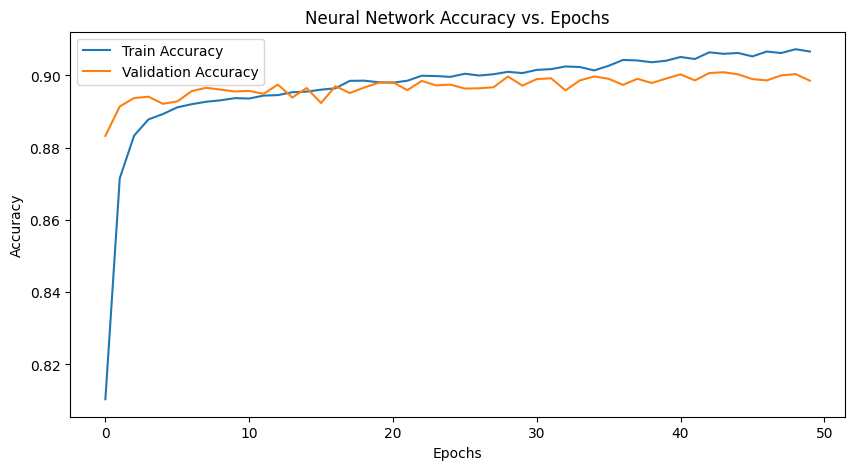

In [14]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Neural Network Accuracy vs. Epochs")
plt.legend()
plt.show()


Step 15: Compare Models

In [15]:
print(f"Random Forest Accuracy: {accuracy_rf * 100:.2f}%")
print(f"Neural Network Accuracy: {accuracy_nn * 100:.2f}%")

if accuracy_rf > accuracy_nn:
    print(" Random Forest performed better!")
else:
    print(" Neural Network performed better!")


Random Forest Accuracy: 91.06%
Neural Network Accuracy: 89.86%
 Random Forest performed better!
